In [110]:
#importing the libraries

import requests
from urllib.request import urlopen
from bs4 import BeautifulSoup
import bs4 as bs
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
import gc
import nltk
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords


In [111]:
#defining the sleep time
sleep_time = 20 

In [112]:
#definig the url and beautiful soup object

url='https://www.imdb.com/search/title/?groups=top_100&sort=user_rating,desc'
source = urllib.request.urlopen(url).read()
soup = bs.BeautifulSoup(source,'lxml')
code = requests.get(url)
print(code)

<Response [200]>


In [113]:
#defining headers

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}


In [114]:
#defining function to extract data

def extract_data(html):
    soup = BeautifulSoup(html, 'html.parser')
    movies = soup.find_all('div', {'class': 'lister-item mode-advanced'})

    data = []
    for movie in movies:
        title = str(movie.h3.a.text.strip())
        rating = float(movie.find('div', {'class': 'ratings-bar'}).strong.text.strip())
        genre = str(movie.find('span', {'class': 'genre'}).text.strip())
        certificate = str(movie.find('span', {'class': 'certificate'}).text.strip())
#       votes = int(movie.find('span', {'name': 'nv'}).text.strip().replace(',', ''))
        directors = [d.text.strip() for d in movie.find_all('p')[2].find_all('a')]
        directors=directors[0]
        actors = [a.text.strip() for a in movie.find_all('p')[2].find_all('a')[1:]]
        try:
            metascore = float(movie.find('span', {'class': 'metascore'}).text.strip())
        except AttributeError:
            metascore = ''
        try:
            runtime = movie.find('span', {'class': 'runtime'}).text.strip()
        except AttributeError:
            runtime = ''
        try:
            gross = int(movie.find('span', {'name': 'nv'})['data-value'])
        except TypeError:
            gross = ''
        year = movie.find('span', {'class': 'lister-item-year'}).text.strip('()')
        data.append([title, rating, genre, certificate, directors, actors, metascore, runtime, gross, year])
        
    

    return data

In [115]:
#defining function to scrape data

def scrape():
    data = []
    for i in range(1, 101):
        page_url = url + '&start=' + str((i - 1) * 50 + 1)
        response = requests.get(page_url, headers=headers)
        if response.status_code == 200:
            html = response.text
            data += extract_data(html)
        else:
            print('Error:', response.status_code)

    columns = ['Title', 'Rating', 'Genre', 'Certificate', 'Directors', 'Actors', 'Metascore', 'Runtime', 'Gross', 'Year']
    df = pd.DataFrame(data, columns=columns)
    return df





In [ ]:
def get_gross(movie_card):
    gross_data = movie_card.find("p", class_="sort-num_votes-visible")
    gross_span = gross_data.find_all("span", text="Gross:")
    if gross_span:
        gross_value = gross_span[0].find_next_sibling("span")
        gross_text = gross_value["data-value"]
        return float(gross_text.replace(',', '')) / 1_000_000
    return None

revenues = []
for movie_card in soup.select('.lister-item.mode-advanced'):
    movie_revenue = get_gross(movie_card)
    revenues.append(movie_revenue)

In [117]:
#dataframe

x.head()

,Title,Rating,Genre,Certificate,Directors,Actors,Metascore,Runtime,Gross,Year
0,The Shawshank Redemption,9.3,Drama,R,Frank Darabont,"[Tim Robbins, Morgan Freeman, Bob Gunton, Will...",82.0,142 min,2730948,1994
1,The Godfather,9.2,"Crime, Drama",R,Francis Ford Coppola,"[Marlon Brando, Al Pacino, James Caan, Diane K...",100.0,175 min,1898781,1972
2,The Dark Knight,9.0,"Action, Crime, Drama",PG-13,Christopher Nolan,"[Christian Bale, Heath Ledger, Aaron Eckhart, ...",84.0,152 min,2704035,2008
3,The Lord of the Rings: The Return of the King,9.0,"Action, Adventure, Drama",PG-13,Peter Jackson,"[Elijah Wood, Viggo Mortensen, Ian McKellen, O...",94.0,201 min,1878690,2003
4,Schindler's List,9.0,"Biography, Drama, History",R,Steven Spielberg,"[Liam Neeson, Ralph Fiennes, Ben Kingsley, Car...",95.0,195 min,1378933,1993


In [118]:
#nature of the varaibles

x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Title        100 non-null    object 
 1   Rating       100 non-null    float64
 2   Genre        100 non-null    object 
 3   Certificate  100 non-null    object 
 4   Directors    100 non-null    object 
 5   Actors       100 non-null    object 
 6   Metascore    100 non-null    object 
 7   Runtime      100 non-null    object 
 8   Gross        100 non-null    int64  
 9   Year         100 non-null    object 
dtypes: float64(1), int64(1), object(8)
memory usage: 7.9+ KB


In [119]:
#cleaning the data

x['Metascore'] = x['Metascore'].replace('', np.NaN)
x['Runtime'] = x['Runtime'].replace('', np.NaN)
x['Runtime'] = x['Runtime'].str.replace(' min', '')
x['Metascore']=x['Metascore'].astype(float)
x['Runtime']=x['Runtime'].astype(float)

In [120]:
#descriptive stats

x.describe()

,Rating,Metascore,Runtime,Gross
count,100.000000,97.000000,100.000000,1.000000e+02
mean,8.516000,83.391753,135.100000,9.424737e+05
std,0.211163,11.614069,31.096948,6.199699e+05
min,8.300000,57.000000,81.000000,4.735900e+04
25%,8.400000,76.000000,112.750000,4.072892e+05
50%,8.500000,85.000000,130.500000,8.866910e+05
75%,8.600000,92.000000,151.250000,1.318072e+06
max,9.300000,100.000000,229.000000,2.730948e+06


In [121]:
# Convert to csv

x.to_csv('imdb_top_movies.csv',index=False)

array([[<AxesSubplot:title={'center':'Rating'}>,
        <AxesSubplot:title={'center':'Metascore'}>],
       [<AxesSubplot:title={'center':'Runtime'}>,
        <AxesSubplot:title={'center':'Gross'}>]], dtype=object)

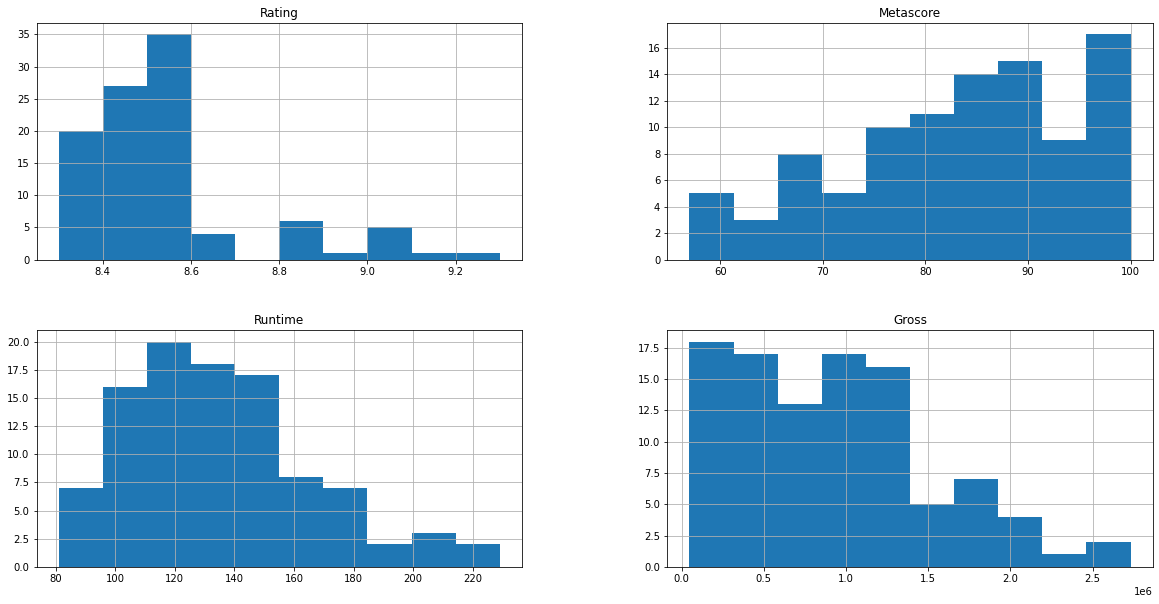

In [122]:
#plotting histograms for numerical variables


x.hist(figsize=(20,10))

Text(0, 0.5, '')

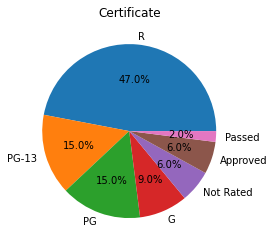

In [123]:
x['Certificate'].value_counts().plot(kind='pie', title='Certificate',autopct='%.1f%%').set_ylabel('')

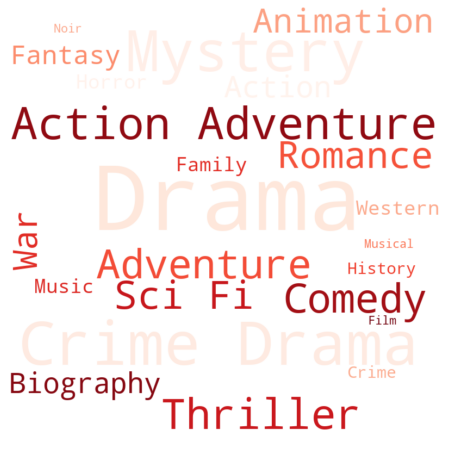

In [124]:
text = " ".join(x['Genre'].str.cat(sep=" ").split(", "))

# Create a WordCloud object with some parameters
wordcloud = WordCloud(width=800, height=800, background_color='white', colormap='Reds', 
                      min_font_size=10).generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

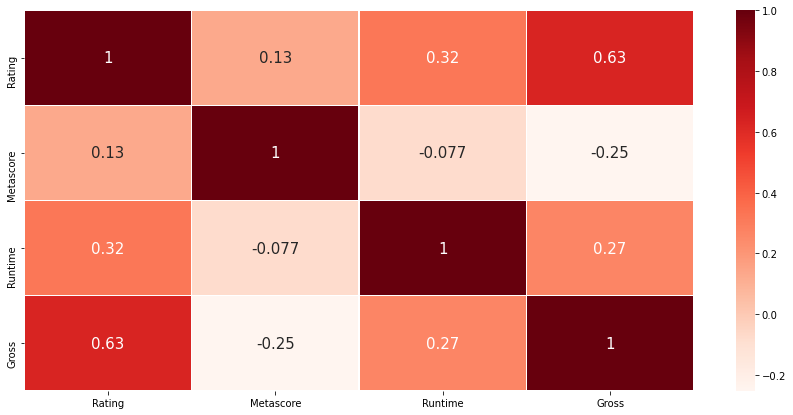

In [125]:
#Coreelation between numnerical varaibles

fig=sns.heatmap(x[['Rating','Metascore','Runtime','Gross']].corr(),annot=True,cmap='Reds',linewidths=0.2,annot_kws={'size':15})
fig=plt.gcf()
fig.set_size_inches(15,7)
plt.show()

<AxesSubplot:xlabel='Certificate', ylabel='Rating'>

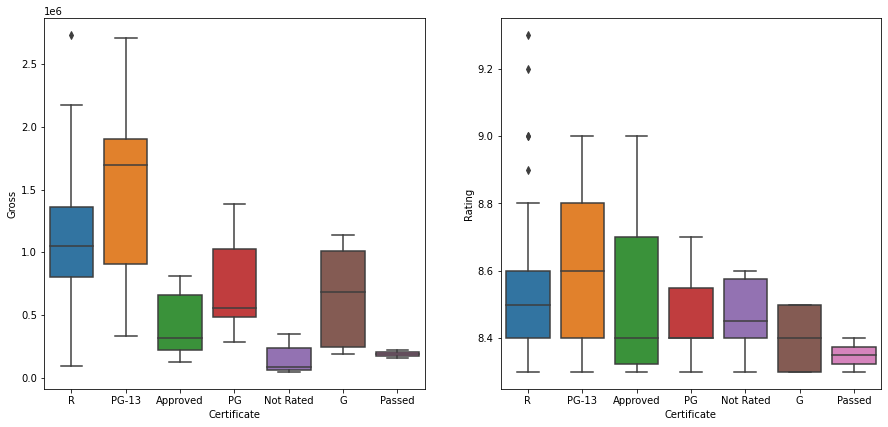

In [126]:
fig = plt.figure(figsize=(15,15))
fig_dims = (2, 2)

plt.subplot2grid(fig_dims, (0,0))
sns.boxplot(x="Certificate", y="Gross", data=x)

plt.subplot2grid(fig_dims, (0,1))
sns.boxplot(x="Certificate", y="Rating", data=x)